In [ ]:
!pip install hopsworks

In [2]:
import hopsworks
import pandas as pd
import joblib
import os
from sklearn.linear_model import LogisticRegression
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectPercentile, chi2

In [4]:
fv_version=1
model_version=2
td_version=1

In [ ]:
import os

# Hosted notebook environments may not have the local features package
def need_download_modules():
    if 'google.colab' in str(get_ipython()):
        return True
    if 'HOPSWORKS_PROJECT_ID' in os.environ:
        return True
    return False

if need_download_modules():
    print("Downloading modules")
    os.system('mkdir -p features')
    os.system('cd features && wget https://raw.githubusercontent.com/jimdowling/hopsworks-tutorials/loan_approval/loan_approval/features/loans.py')
    os.system('cd features && wget https://raw.githubusercontent.com/jimdowling/hopsworks-tutorials/loan_approval/loan_approval/features/applicants.py')
else:
    print("Local environment")

In [6]:
import hopsworks

proj = hopsworks.login()
fs = proj.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/398


Connected. Call `.close()` to terminate connection gracefully.


In [7]:
fv = fs.get_feature_view(name="loans_approvals", version=fv_version)

In [8]:
fv.init_batch_scoring(training_dataset_version=td_version)

In [9]:
def retrieve_data(feature_view):
    batch_data = feature_view.get_batch_data()
    return batch_data

df = retrieve_data(fv)
df

2023-04-03 22:41:28,348 INFO: USE `dowlingj_featurestore`
2023-04-03 22:41:29,019 INFO: WITH right_fg0 AS (SELECT *
FROM (SELECT `fg1`.`loan_amnt` `loan_amnt`, `fg1`.`term` `term`, `fg1`.`int_rate` `int_rate`, `fg1`.`installment` `installment`, `fg1`.`sub_grade` `sub_grade`, `fg1`.`purpose` `purpose`, `fg1`.`zip_code` `zip_code`, `fg1`.`id` `join_pk_id`, `fg1`.`issue_d` `join_evt_issue_d`, `fg0`.`earliest_cr_line_year` `earliest_cr_line_year`, `fg0`.`home_ownership` `home_ownership`, `fg0`.`annual_inc` `annual_inc`, `fg0`.`verification_status` `verification_status`, `fg0`.`dti` `dti`, `fg0`.`open_acc` `open_acc`, `fg0`.`pub_rec` `pub_rec`, `fg0`.`revol_bal` `revol_bal`, `fg0`.`revol_util` `revol_util`, `fg0`.`total_acc` `total_acc`, `fg0`.`initial_list_status` `initial_list_status`, `fg0`.`application_type` `application_type`, `fg0`.`mort_acc` `mort_acc`, `fg0`.`pub_rec_bankruptcies` `pub_rec_bankruptcies`, RANK() OVER (PARTITION BY `fg1`.`id`, `fg1`.`issue_d` ORDER BY `fg0`.`earliest_

,loan_amnt,term,int_rate,installment,sub_grade,purpose,zip_code,earliest_cr_line_year,home_ownership,annual_inc,...,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies
0,10000.0,36 months,11.44,329.48,B4,vacation,22690,1990,RENT,117000.0,...,26.24,16.0,0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0
1,8000.0,36 months,11.99,265.68,B5,debt_consolidation,0,2004,MORTGAGE,65000.0,...,22.05,17.0,0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0
2,15600.0,36 months,10.49,506.97,B3,credit_card,0,2007,RENT,43057.0,...,12.79,13.0,0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0
3,7200.0,36 months,6.49,220.65,A2,credit_card,0,2006,RENT,54000.0,...,2.60,6.0,0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0
4,24375.0,60 months,17.27,609.33,C5,credit_card,11650,1999,MORTGAGE,55000.0,...,33.95,13.0,0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395214,10000.0,60 months,10.99,217.38,B4,debt_consolidation,30723,2004,RENT,40000.0,...,15.63,6.0,0,1990.0,34.3,23.0,w,INDIVIDUAL,0.0,0.0
395215,21000.0,36 months,12.29,700.42,C1,debt_consolidation,0,2006,MORTGAGE,110000.0,...,21.45,6.0,0,43263.0,95.7,8.0,f,INDIVIDUAL,1.0,0.0
395216,5000.0,36 months,9.99,161.32,B1,debt_consolidation,70466,1997,RENT,56500.0,...,17.56,15.0,0,32704.0,66.9,23.0,f,INDIVIDUAL,0.0,0.0
395217,21000.0,60 months,15.31,503.02,C2,debt_consolidation,29597,1990,MORTGAGE,64000.0,...,15.88,9.0,0,15704.0,53.8,20.0,f,INDIVIDUAL,5.0,0.0


In [10]:
def get_model(project):
    mr = project.get_model_registry()
    model = mr.get_model("lending_model", version=model_version)
    model_dir = model.download()
    return joblib.load(model_dir + "/lending_model.pkl")

model = get_model(proj)

Connected. Call `.close()` to terminate connection gracefully.


In [11]:
predictions = model.predict(df)
predictions

array([1, 1, 1, ..., 1, 1, 1])

In [13]:
np.unique(predictions, return_counts=True)

(array([0, 1]), array([ 37396, 357823]))

In [18]:
cols = []
for td in fv.schema:
    cols.append(td.name)

predictions_df = pd.DataFrame(predictions, columns=["prediction"])
predictions_df

,prediction
0,1
1,1
2,1
3,1
4,0
...,...
395214,1
395215,1
395216,1
395217,1


In [19]:
import time

fg = fs.get_feature_group(name="loans", version=1)
labels_df = fg.read()

2023-04-03 23:03:13,909 INFO: USE `dowlingj_featurestore`
2023-04-03 23:03:14,390 INFO: SELECT `fg0`.`id` `id`, `fg0`.`loan_amnt` `loan_amnt`, `fg0`.`term` `term`, `fg0`.`int_rate` `int_rate`, `fg0`.`installment` `installment`, `fg0`.`sub_grade` `sub_grade`, `fg0`.`issue_d` `issue_d`, `fg0`.`loan_status` `loan_status`, `fg0`.`purpose` `purpose`, `fg0`.`zip_code` `zip_code`
FROM `dowlingj_featurestore`.`loans_1` `fg0`


,loan_amnt,term,int_rate,installment,sub_grade,purpose,zip_code,earliest_cr_line_year,home_ownership,annual_inc,...,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,prediction,outcome,prediction_ts
0,10000.0,36 months,11.44,329.48,B4,vacation,22690,1990,RENT,117000.0,...,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,1,Fully Paid,2023/04/03
1,8000.0,36 months,11.99,265.68,B5,debt_consolidation,0,2004,MORTGAGE,65000.0,...,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,1,Charged Off,2023/04/03
2,15600.0,36 months,10.49,506.97,B3,credit_card,0,2007,RENT,43057.0,...,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,1,Fully Paid,2023/04/03
3,7200.0,36 months,6.49,220.65,A2,credit_card,0,2006,RENT,54000.0,...,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,1,Fully Paid,2023/04/03
4,24375.0,60 months,17.27,609.33,C5,credit_card,11650,1999,MORTGAGE,55000.0,...,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,0,Fully Paid,2023/04/03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395214,10000.0,60 months,10.99,217.38,B4,debt_consolidation,30723,2004,RENT,40000.0,...,1990.0,34.3,23.0,w,INDIVIDUAL,0.0,0.0,1,Fully Paid,2023/04/03
395215,21000.0,36 months,12.29,700.42,C1,debt_consolidation,0,2006,MORTGAGE,110000.0,...,43263.0,95.7,8.0,f,INDIVIDUAL,1.0,0.0,1,Fully Paid,2023/04/03
395216,5000.0,36 months,9.99,161.32,B1,debt_consolidation,70466,1997,RENT,56500.0,...,32704.0,66.9,23.0,f,INDIVIDUAL,0.0,0.0,1,Fully Paid,2023/04/03
395217,21000.0,60 months,15.31,503.02,C2,debt_consolidation,29597,1990,MORTGAGE,64000.0,...,15704.0,53.8,20.0,f,INDIVIDUAL,5.0,0.0,1,Charged Off,2023/04/03


In [28]:
monitor_df = df.copy()
monitor_df['prediction'] = predictions_df

monitor_df['prediction'] = predictions_df.prediction.map({1:'Fully Paid', 0:'Charged Off'})

monitor_df['outcome'] = labels_df['loan_status']
monitor_df['prediction_ts'] = pd.datetime.now()

monitor_df['id'] = monitor_df.index

monitor_df

,loan_amnt,term,int_rate,installment,sub_grade,purpose,zip_code,earliest_cr_line_year,home_ownership,annual_inc,...,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,prediction,outcome,prediction_ts,id
0,10000.0,36 months,11.44,329.48,B4,vacation,22690,1990,RENT,117000.0,...,41.8,25.0,w,INDIVIDUAL,0.0,0.0,Fully Paid,Fully Paid,2023-04-03 23:21:38.242875,0
1,8000.0,36 months,11.99,265.68,B5,debt_consolidation,0,2004,MORTGAGE,65000.0,...,53.3,27.0,f,INDIVIDUAL,3.0,0.0,Fully Paid,Charged Off,2023-04-03 23:21:38.242875,1
2,15600.0,36 months,10.49,506.97,B3,credit_card,0,2007,RENT,43057.0,...,92.2,26.0,f,INDIVIDUAL,0.0,0.0,Fully Paid,Fully Paid,2023-04-03 23:21:38.242875,2
3,7200.0,36 months,6.49,220.65,A2,credit_card,0,2006,RENT,54000.0,...,21.5,13.0,f,INDIVIDUAL,0.0,0.0,Fully Paid,Fully Paid,2023-04-03 23:21:38.242875,3
4,24375.0,60 months,17.27,609.33,C5,credit_card,11650,1999,MORTGAGE,55000.0,...,69.8,43.0,f,INDIVIDUAL,1.0,0.0,Charged Off,Fully Paid,2023-04-03 23:21:38.242875,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395214,10000.0,60 months,10.99,217.38,B4,debt_consolidation,30723,2004,RENT,40000.0,...,34.3,23.0,w,INDIVIDUAL,0.0,0.0,Fully Paid,Fully Paid,2023-04-03 23:21:38.242875,395214
395215,21000.0,36 months,12.29,700.42,C1,debt_consolidation,0,2006,MORTGAGE,110000.0,...,95.7,8.0,f,INDIVIDUAL,1.0,0.0,Fully Paid,Fully Paid,2023-04-03 23:21:38.242875,395215
395216,5000.0,36 months,9.99,161.32,B1,debt_consolidation,70466,1997,RENT,56500.0,...,66.9,23.0,f,INDIVIDUAL,0.0,0.0,Fully Paid,Fully Paid,2023-04-03 23:21:38.242875,395216
395217,21000.0,60 months,15.31,503.02,C2,debt_consolidation,29597,1990,MORTGAGE,64000.0,...,53.8,20.0,f,INDIVIDUAL,5.0,0.0,Fully Paid,Charged Off,2023-04-03 23:21:38.242875,395217


In [27]:
loan_monitoring_fg = fs.get_or_create_feature_group(name="loan_monitoring",
                                    version=1,
                                    description="Lending Club Loan Predictions and Outcomes",
                                    primary_key=['id'],
                                    event_time='prediction_ts'
)

In [29]:
loan_monitoring_fg.insert(monitor_df, write_options={"wait_for_job" : False})

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/398/fs/335/fg/31293


Uploading Dataframe: 0.00% |          | Rows 0/395219 | Elapsed Time: 00:00 | Remaining Time: ?

Launching offline feature group backfill job...
Backfill Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/398/jobs/named/loan_monitoring_1_offline_fg_backfill/executions


(<hsfs.core.job.Job at 0x7f894b915130>, None)

In [30]:
from sklearn.metrics import confusion_matrix

predictions = monitor_df[['prediction']]
labels = monitor_df[['outcome']]

results = confusion_matrix(labels, predictions)
print(results)

[[  7289  70224]
 [ 30107 287599]]


,Predicted Defaulted,Predicted Paid Off
True Defaulted,7289,70224
True Paid Off,30107,287599


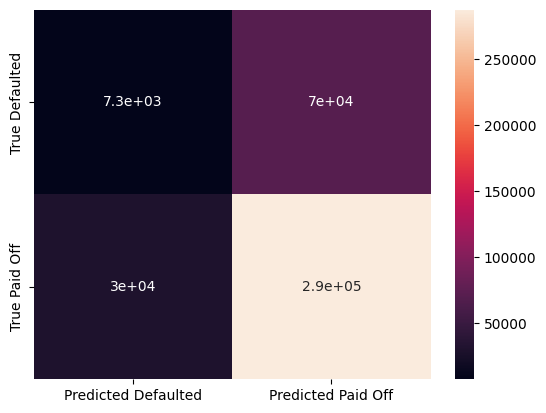

In [35]:
from matplotlib import pyplot
import seaborn as sns

df_cm = pd.DataFrame(results, ['True Defaulted', 'True Paid Off'],
                     ['Predicted Defaulted','Predicted Paid Off'])

cm = sns.heatmap(df_cm, annot=True)

fig = cm.get_figure()
fig.savefig("./confusion_matrix.png") 
df_cm

In [36]:
dataset_api = proj.get_dataset_api()    
dataset_api.upload("./confusion_matrix.png", "Resources/images", overwrite=True)

Uploading: 0.000%|          | 0/21818 elapsed<00:00 remaining<?

'Resources/images/confusion_matrix.png'